# Machine Learning and Statistics Project 2020

## Introduction 

In this project contains a web service that uses machine learning to make predictions based on the data set powerproduction available on Moodle. The goal is to
produce a model that accurately predicts wind turbine power output from wind speed values, as in the data set.
The web service that will respond with predicted power values based on speed values sent as HTTP requests. 
This project contains the following 
1. Jupyter notebook that trains a model using the data set. Description of the model and give an analysis of its accuracy.
2. Python web service based on the model.
3. Dockerfile to build and run the web service in a container.
4. Standard items in a git repository such as a README

In [205]:
# import liberires used in project 
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, accuracy_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import cdist 
import matplotlib.pyplot as plt 
from tensorflow.keras.layers.experimental import preprocessing


### The Dataset

This study we try to clustering power production using  Linear Regression Kmeans and tensorflow

Attribute Information:

$$speed  (\frac{km}{s})$$
$$power (W)$$


###  Loading the data set
We will be loading the powerproduction excel file using pandas. 

In [206]:
df = pd.read_csv("powerproductionDataSet.csv")

## Explore the dataset 

In [207]:
for _ in df.columns:
    print("The number of null values in:{} == {}".format(_, df[_].isnull().sum()))

The number of null values in:speed == 0
The number of null values in:power == 0


The method above shows that dataset has no null values 

In [208]:
df.shape

(500, 2)

Using the shape method as below shows that dataset has 500 rows and 2 columns. Look at what the  dataset actually looks like. To do this, use the head() method:

In [209]:
df.head()

,speed,power
0,0.000,0.0
1,0.125,0.0
2,0.150,0.0
3,0.225,0.0
4,0.275,0.0


 ### Statistical details of the dataset

In [210]:
df.describe()

,speed,power
count,500.000000,500.000000
mean,12.590398,48.014584
std,7.224991,41.614572
min,0.000000,0.000000
25%,6.324750,5.288000
50%,12.550500,41.645500
75%,18.775250,93.537000
max,25.000000,113.556000


The described method will help to see how data has been spread. Shows that the  minimum value, mean values, different percentile values, and maximum values.

### Test if any missing data in the dataset

In [211]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   speed   500 non-null    float64
 1   power   500 non-null    float64
dtypes: float64(2)
memory usage: 7.9 KB


With the info() shows that both columns of the dataset are of type float 

#### Violin Plots 

<AxesSubplot:ylabel='speed'>

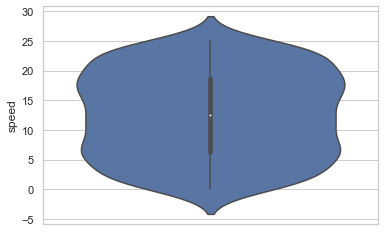

In [212]:
sns.set_theme(style="whitegrid")

sns.violinplot(y=df["speed"])

As shown on the graph the interquartile range is between 6 and 19

<AxesSubplot:ylabel='power'>

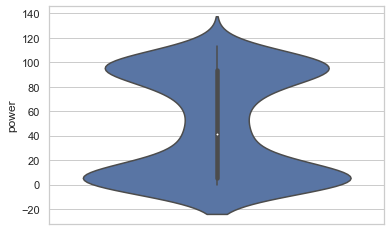

In [213]:
sns.violinplot(y=df["power"])

The two variables have multimodal distribution, thus its a mixture of two Gaussian distributions. Has a large interquartile large between 5 and 93 as shown on describe function as above.

In [214]:
correlations = df.corr()
correlations

,speed,power
speed,1.000000,0.853778
power,0.853778,1.000000


The relationship between speed and power is generally considered strong when their r value is .853. Thus shows that power generated depends on speed. 

## Prediction Models

### Basic Regression 

#### Let’s have a look at our data through a scatter plot.

<AxesSubplot:xlabel='speed', ylabel='power'>

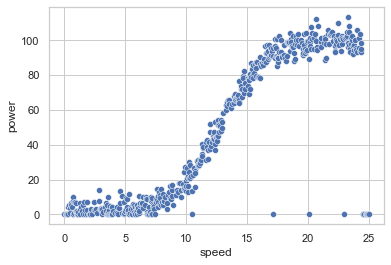

In [215]:
sns.scatterplot(data=df, x="speed", y="power")

It looks like the some of the data from speed 7km/s to 16km/s data might indeed be linear. The points don't exactly fit on a straight line, but they are not far off it. Data below and over that have more like an expontial relationships with different decay rates .



#### Minimising the cost
We want to calculate values of $m$ and $c$ that give the lowest value for the cost value above. For our given data set we can plot the cost value/function.

$$ Cost(m, c) = \sum_i (y_i - mx_i - c)^2 $$

The polyfit function and manually method below will do that

In [216]:
np.polyfit(df['speed'],df['power'],1)

array([  4.91759567, -13.89990263])

In [217]:
# Calculate mean x and mean y.
x_avg = np.mean(df['speed'])
y_avg = np.mean(df['power'])

# Subtract means from x and y.
x_zero = df['speed'] - x_avg
y_zero = df['power'] - y_avg

# Dot product of mean-adjusted x and y divided by dot product of mean adjusted x with itself.
m = np.sum(x_zero * y_zero) / np.sum(x_zero * x_zero)
# Subtract m times average x from average y.
c = y_avg - m * x_avg

# Let's have a look - same values as above.
m, c

(4.917595665404668, -13.899902630519605)

Text(0.5, 1.0, 'Plot of the best fit with regression 4.9x-13.89')

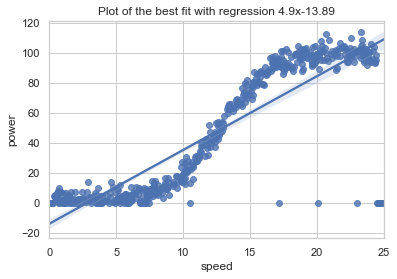

In [218]:
sns.regplot(x="speed", y="power",  data=df)
plt.title('Plot of the best fit with regression 4.9x-13.89')

Best fit line
So, the best values for $m$ and $c$ given our data and using least squares fitting are about $4.9$ for $m$ and about $-13.89$ for $c$

$$y=4.9x -13.89$$

In [219]:

# Calculate the cost of the lines above for the data above.
cost = lambda m,c: np.sum([(df['speed'][i] - m * df['power'][i] - c)**2 for i in range(df['power'].size)])
cost(4.9, -13.89)

41315933.734039105

<AxesSubplot:ylabel='speed'>

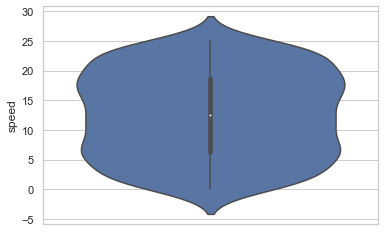

In [220]:
sns.set_theme(style="whitegrid")

sns.violinplot(y=df["speed"])

As shown on the graph the interquartile range is between 6 and 19 

<AxesSubplot:ylabel='power'>

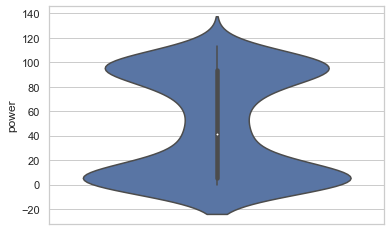

In [221]:
sns.set_theme(style="whitegrid")
sns.violinplot(y=df["power"])

The two variables have multimodal distribution, thus its a mixture of two Gaussian distributions.

### SkLearn linear regresssion 

Linear regression is a predictive model. Linear regression seeks to predict the relationship between a scalar response and related explanatory variables to output value with realistic meaning like product sales or housing prices.
This model is best used when you have a log of previous, consistent data and want to predict what will happen next if the pattern continues.
From a mathematical point of view, linear regression is about fitting data to minimize the sum of residuals between each data point and the predicted value. In other words, we are minimizing the discrepancy between the data and the estimation model.[[7]](https://www.educative.io/blog/scikit-learn-tutorial-linear-regression)

'*LinearRegression fits a linear model with coefficients w = (w1, …, wp) to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation*'.[[6]](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

Code for the model below is based on [[9]](https://www.kaggle.com/andyxie/beginner-scikit-learn-linear-regression-tutorial)

In [222]:
# Sperate train and test data
X_train, X_test, y_train, y_test = train_test_split(df[['speed']], df['power'], test_size=0.2, random_state=0)


The above script splits 80% of the data to training set while 20% of the data to test set. The test_size variable is where we actually specify the proportion of test set.

In [223]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

LinearRegression()

In [224]:
regressor.intercept_

-13.603433993820197

In [225]:
regressor.coef_

array([4.89542079])

Thus equation of the line using sklearn linear regression is 

$$y= 4.89-13.6 $$ 

### Making Predictions

With the trained  algorithm, it's time to make some predictions. To do so use the test data and see how accurately this algorithm predicts the percentage score. To make pre-dictions on the test data

In [226]:
y_pred = regressor.predict(X_test)

In [227]:
df_diff = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_diff['x_Test'] =X_test


### Evaluating the Algorithm

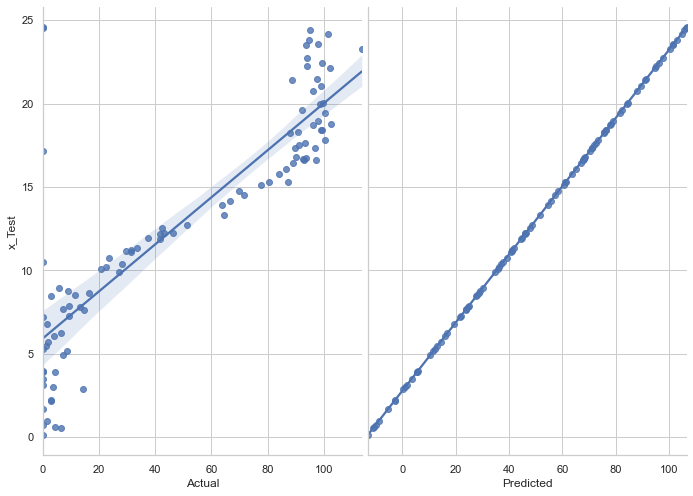

In [228]:
sns.pairplot(df_diff, x_vars=['Actual','Predicted'], y_vars='x_Test', height=7, aspect=0.7, kind='reg')

In [229]:
cost = np.sum((regressor.predict(df[['speed']]) - df['power']) ** 2)
cost


234254.1218983738

This shows that the this is a best fit than using basic regresssion as the cost function here is 234254 which is less than for basic regression which is 41315933 . 

#### Mean absolute error

In [230]:
y_hat = regressor.predict(df[['speed']])
mae = mean_absolute_error(df['power'], y_hat)
mae

14.506662948434963

## KMeans Clustering and Linear Regresssion

K-Means Clustering is an unsupervised machine learning algorithm. K-Means trys to classify data without having first been trained with labeled data. Once the algorithm has been run and the groups are defined, any new data can be easily assigned to the most relevant group [[2]](https://towardsdatascience.com/machine-learning-algorithms-part-9-k-means-example-in-python-f2ad05ed5203)

### How it works 
1. Select K (i.e. 2) random points as cluster centers called centroids
2. Assign each data point to the closest cluster by calculating its distance with respect to each centroid
3. Determine the new cluster center by computing the average of the assigned points
4. Repeat steps 2 and 3 until none of the cluster assignments change

### Choosing the right number of clusters (Elbow Method)
A graph of the relationship between the number of clusters and Within Cluster Sum of Squares (WCSS) then select the number of clusters where the change in WCSS begins to level off (elbow method). WCSS is defined as the sum of the squared distance between each member of the cluster and its centroid.

$$WSS=\sum^m_{i=1}(x_i -c_i)^2$$

In [231]:
# Code from https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 

for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(df) 
    kmeanModel.fit(df)

    distortions.append(sum(np.min(cdist(df, kmeanModel.cluster_centers_, 'euclidean'),axis=1)) / df.shape[0]) 
    inertias.append(kmeanModel.inertia_) 

    mapping1[k] = sum(np.min(cdist(df, kmeanModel.cluster_centers_, 'euclidean'),axis=1)) / df.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 


In [232]:
for key,val in mapping1.items(): 
    print(str(key)+' : '+str(val))

1 : 39.794016660463875
2 : 11.481870938448166
3 : 7.7370585714187055
4 : 6.149803457487902
5 : 5.406421043319489
6 : 4.889577711535056
7 : 4.234754581533216
8 : 3.6689364360562817
9 : 3.3452118284614563


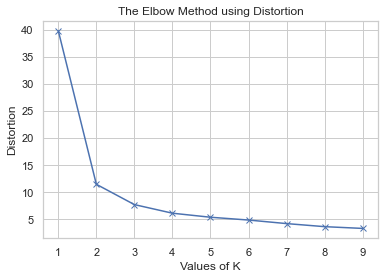

In [233]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()

To determine the optimal number of clusters,select the value of k at the elbow ie the point after which the distortion/inertia start decreasing in a linear fashion. Thus concludes that the optimal number of clusters for the data is 3.

Next, categorize the data using the optimum number of clusters (3)  k-means++ ensures that you get don’t fall into the random initialization trap.

### K-means clustering algorithm
- The initial centroids (cluster centers) are chosen. In this model k-means++ is used. This algorithm ensures a smarter initialization of the centroids and improves the quality of the clustering. Apart from initialization, the rest of the algorithm is the same as the standard K-means algorithm. That is K-means++ is the standard K-means algorithm coupled with a smarter initialization of the centroids[[10]](https://www.geeksforgeeks.org/ml-k-means-algorithm/)
Centroid assignment: each sample in the dataset is assigned to the nearest centroid.
Centroid correction: new centroids are created by computing new means for the assignments created in step 2.
Difference comparison: for each centroid, the difference between old and new is compared, and the algorithm stops when the difference is lower than a threshold called inertia, or tolerance. Otherwise, it moves back to step 2.

In [234]:

kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
kmeans.fit(df)

KMeans(n_clusters=3, random_state=0)

In [235]:
y_kmeans = kmeans.fit_predict(df)

df['label']= y_kmeans



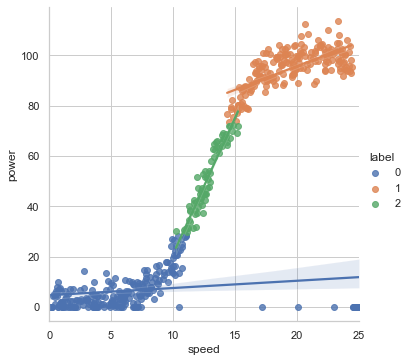

In [236]:
sns.lmplot(x="speed", y="power", hue='label', data=df)

#### Linear Regression on each of the clusters 

In [237]:
np.polyfit(df.loc[y_kmeans == 0]['speed'],df.loc[y_kmeans == 0]['power'],1)

array([0.28798421, 4.65969275])

Thus equation of the line using sklearn linear regression is for cluster 0 is 

$$y=.287x + 4.6 $$

Text(0.5, 1.0, 'Cluster 0 best fit is .287x + 4.6')

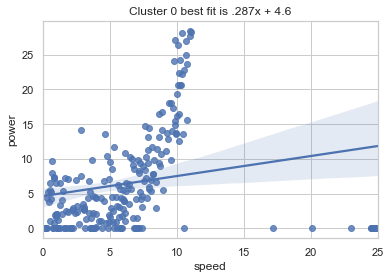

In [238]:
sns.regplot(x="speed", y="power", data=df.loc[y_kmeans == 0])
plt.title("Cluster 0 best fit is .287x + 4.6")

In [239]:
cluster_0df = df.loc[y_kmeans == 0]

X_train0, X_test0, y_train0, y_test0 = train_test_split(cluster_0df[['speed']], cluster_0df['power'], test_size=0.2, random_state=0)
regressor.fit(X_train0, y_train0)

y_hat0 = regressor.predict(cluster_0df[['speed']])
mae0 = mean_absolute_error(cluster_0df['power'], y_hat0)

mae0

5.243273986109941

In [240]:
np.polyfit(df.loc[y_kmeans == 1]['speed'],df.loc[y_kmeans == 1]['power'],1)

array([ 1.88269278, 57.99808409])

Thus equation of the line using sklearn linear regression is for cluster 1 is 

$$y=1.88x + 57.99 $$

Text(0.5, 1.0, 'Best fit for cluster 1 is 1.88x + 57.99')

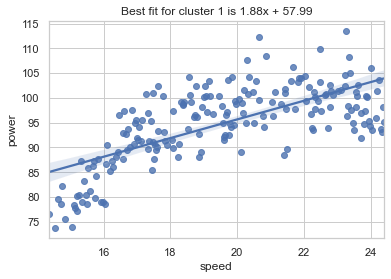

In [241]:
sns.regplot(x="speed", y="power", data=df.loc[y_kmeans == 1])
plt.title("Best fit for cluster 1 is 1.88x + 57.99")                                             

In [242]:
cluster_1df = df.loc[y_kmeans == 1]
X_train1, X_test1, y_train1, y_test1 = train_test_split(cluster_1df[['speed']], cluster_1df['power'], test_size=0.2, random_state=0)
regressor.fit(X_train1, y_train1)

y_hat1 = regressor.predict(cluster_1df[['speed']])
mae1 = mean_absolute_error(cluster_1df['power'], y_hat1)

mae1

4.501695063897006

In [243]:
np.polyfit(df.loc[y_kmeans == 2]['speed'],df.loc[y_kmeans == 2]['power'],1)

array([ 10.81992429, -87.2296644 ])

Thus equation of the line using sklearn linear regression is for cluster 2 is 

$$y=10.81x + 87.22 $$

Text(0.5, 1.0, 'best fit for cluster 2 is 10.81x - 87.22')

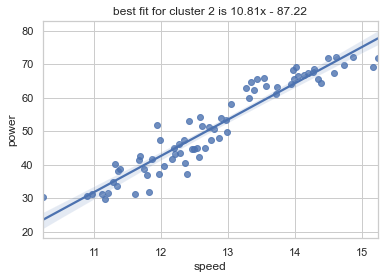

In [244]:
sns.regplot(x="speed", y="power", data=df.loc[y_kmeans == 2])
plt.title('best fit for cluster 2 is 10.81x - 87.22')

In [245]:
cluster_2df = df.loc[y_kmeans == 2]
X_train2, X_test2, y_train2, y_test2 = train_test_split(cluster_2df[['speed']], cluster_2df['power'], test_size=0.2, random_state=0)
regressor.fit(X_train2, y_train2)

y_hat2 = regressor.predict(cluster_2df[['speed']])
mae2 = mean_absolute_error(cluster_2df['power'], y_hat2)

mae2

3.3410175212889417

In [246]:
cluster_2df.describe()

,speed,power,label
count,73.000000,73.000000,73.0
mean,12.799753,51.262699,2.0
std,1.174900,13.371341,0.0
min,10.235000,29.601000,2.0
25%,11.937000,40.519000,2.0
50%,12.613000,49.796000,2.0
75%,13.739000,64.541000,2.0
max,15.240000,72.135000,2.0


### Neural network regression tensorflow keras

In [247]:
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)


Split features from labels
Separate the target value, the "label", from the features. This label is the value that you will train the model to predict.

In [248]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('power')
test_labels = test_features.pop('power')

### Normailzation
It is good practice to normalize features that use different scales and ranges.

One reason this is important is because the features are multiplied by the model weights. So the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.

Although a model might converge without feature normalization, normalization makes training much more stable.[[3]](https://www.tensorflow.org/tutorials/keras/regression)

First create the speed Normalization layer:

In [249]:
speed = np.array(train_features['speed'])
speed_normalizer = preprocessing.Normalization(input_shape=[1,])
speed_normalizer.adapt(speed)



### Design of model 

Define each layer of the neural network and connect them together so data flows from first layer to last layer

In [250]:
speed_model = tf.keras.Sequential([
    speed_normalizer,
    tf.keras.layers.Dense(50, input_shape=(1,), activation='sigmoid', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform")
])
speed_model.add(tf.keras.layers.Dense(1, activation='linear', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
speed_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_3 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                100       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
Total params: 154
Trainable params: 151
Non-trainable params: 3
_________________________________________________________________


Once the model is built, configure the training procedure using the Model.compile() method. The most important arguments to compile are the loss and the optimizer since these define what will be optimized (mean_absolute_error) and how (using the optimizers.Adam).[[3]](https://www.tensorflow.org/tutorials/keras/regression)
Once the training is configured, use Model.fit() to execute the training:

In [251]:
speed_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [252]:
%%time
history = speed_model.fit(
    train_features['speed'], train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)






Wall time: 6.62 s


In [253]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,5.840698,4.853921,95
96,5.847687,5.423251,96
97,5.871665,5.028625,97
98,5.923624,4.904691,98
99,5.827651,5.213801,99


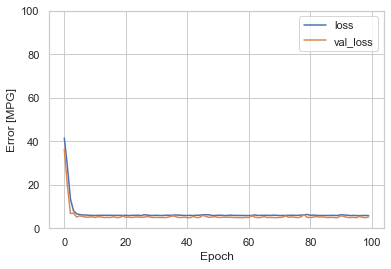

In [254]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Error [MPG]')
plt.legend()
plt.grid(True)

In [255]:
test_results = {}

test_results['speed_model'] = speed_model.evaluate(
    test_features['speed'],
    test_labels, verbose=0)

In [260]:


y = speed_model.predict(test_features['speed'])

In [261]:
q = speed_model.predict([15.5])
q

array([[83.6946]], dtype=float32)

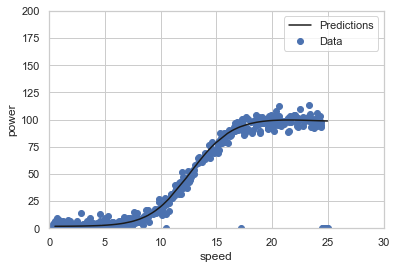

In [258]:
test_results = {}

test_results['speed_model'] = speed_model.evaluate(
    test_features['speed'],
    test_labels, verbose=0)

plt.scatter(train_features['speed'], train_labels, label='Data')
plt.plot(test_features['speed'], y, color='k', label='Predictions')
plt.ylim([0, 200])
plt.xlim([0, 30])
plt.xlabel('speed')
plt.ylabel('power')
plt.legend()

In [259]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
speed_model,6.194578


## Conclusion 

- Out of the three models studied for this project, the neural network gave the most accurate results with (Mean Absolute Error) mae of  6.195 while linear regression for the entire dataset the mae is  14.5.
 
- For the kmeans Cluster 2 which  had speeds between 10km/s and 15km/s and power between 29kW ans 72kW. The mean absolute error for this cluster is 3.3410175212889417 . The interquartile range for speed on the entire dataset 6.3km/s and 18.7km thus Cluster 2 covers most of the interquartile range .

 

# Referenses 

1. GeeksForGeeks, Elbow Method for optimal value of k in KMeans,  https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/

2. Cory Maklin, Dec 28, 2018, K-means Clustering Python Example, https://towardsdatascience.com/machine-learning-algorithms-part-9-k-means-example-in-python-f2ad05ed5203

3. TensorFlow Core, Tutorials, Basic regression: Predict fuel efficiency, https://www.tensorflow.org/tutorials/keras/regression

4. Roman Paolucci, Sep 20, 2020, Linear Regression v.s. Neural Networks, https://towardsdatascience.com/linear-regression-v-s-neural-networks-cd03b2938

5. GUEST BLOG, AUGUST 27, 2020,Exploratory Data Analysis(EDA) in Python!, https://www.analyticsvidhya.com/blog/2020/08/exploratory-data-analysiseda-from-scratch-in-python/

6. sklearn, sklearn.linear_model.LinearRegression,  https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

7. Laerd Statistics, Pearson Product-Moment Correlation, https://statistics.laerd.com/statistical-guides/pearson-correlation-coefficient-statistical-guide.php

8. Ryan Thelin, Oct 20, 2013, https://www.educative.io/blog/scikit-learn-tutorial-linear-regression

9. No Source,2018,Kaggle, Beginner Scikit-learn Linear Regression Tutorial,https://www.kaggle.com/andyxie/beginner-scikit-learn-linear-regression-tutorial

10. GeeksForGeeks, ML | K-means++ Algorithm, https://www.geeksforgeeks.org/ml-k-means-algorithm/


